In [5]:
from inference.run_inference import scrape_and_predict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sentiment_model.evaluation import run_evaluation
import pandas as pd
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sentiment_model.data_utils.tweet_dataset import tokenize, process_token_list
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import os
from utils import get_project_root
from torchtext.vocab import GloVe
import torch
from sentiment_model.data_utils.tweet_dataset import TweetDataset
from pathlib import Path
from sklearn.calibration import CalibratedClassifierCV
from sentiment_model.model_calibration import predict
from sklearn.metrics import classification_report
from utils import pickle_load

## Model evaluation

def score_to_cat(predictions: np.array):
    return np.digitize(predictions, [1/3,2/3, 1], right=True)

def transform_sent140_labels(labels):
    return np.digitize(labels, [0.1, 0.6, 1], right=True)

In [2]:
preds, targets, CM, model = run_evaluation(model_file="lemon-forest-81/lemon-forest-81-epoch-1.pth", num_classes=2, dataset="sent140_multi_class", decision_bound=(0.5208333333333334, 0.625), calib_model_path="cm_model.p")
# preds = score_to_cat(preds_probs)
# targets = transform_sent140_labels(targets)

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Calibrating model


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Test set accuracy: 0.5963855421686747


In [7]:
CM_copy = pickle_load("sentiment_model/checkpoints/cm_model.p")

In [10]:
# Import GloVe Embeddings
cache_path = os.path.join(get_project_root(), Path("sentiment_model/.vector_cache/"))
glove_twitter = GloVe(name="twitter.27B", dim=50, cache=cache_path)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters and padded characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))

# Load data:
test_dataset = TweetDataset(dataset="sent140_multi_class", split="test", pretrained_vecs=glove_twitter)

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
CM_copy.predict_proba(test_dataset)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\20172613\Anaconda3\envs\honors\lib\site-packages\torch\nn\modules\rnn.py:777: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,
100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


array([[0.22063104, 0.77936896],
       [0.05191945, 0.94808055],
       [0.2463721 , 0.7536279 ],
       [0.15493998, 0.84506002],
       [0.28626482, 0.71373518],
       [0.06153747, 0.93846253],
       [0.92792323, 0.07207677],
       [0.04383188, 0.95616812],
       [0.04650448, 0.95349552],
       [0.71812085, 0.28187915],
       [0.03692287, 0.96307713],
       [0.48514489, 0.51485511],
       [0.62598996, 0.37401004],
       [0.05379238, 0.94620762],
       [0.27945886, 0.72054114],
       [0.71604882, 0.28395118],
       [0.84548628, 0.15451372],
       [0.04524852, 0.95475148],
       [0.79123867, 0.20876133],
       [0.09257979, 0.90742021],
       [0.0849027 , 0.9150973 ],
       [0.05560319, 0.94439681],
       [0.45206339, 0.54793661],
       [0.13498064, 0.86501936],
       [0.80874483, 0.19125517],
       [0.03780284, 0.96219716],
       [0.65204337, 0.34795663],
       [0.0790994 , 0.9209006 ],
       [0.0435272 , 0.9564728 ],
       [0.37768306, 0.62231694],
       [0.

In [32]:
def create_test_df(preds, targets, softmax_output=False):
    if softmax_output:
        preds = np.argmax(preds, axis=1)
    labels = ['negative', 'neutral', 'positive']
    text_labels = [labels[int(i)] for i in preds]
    target_labels = [labels[int(i)] for i in targets]

    return pd.DataFrame({"target": target_labels, "predictions": text_labels})

test_df = create_test_df(preds, targets)
print(classification_report(y_true=targets, y_pred=preds))

,target,predictions
0,positive,positive
1,positive,positive
2,positive,positive
3,positive,positive
4,positive,neutral
...,...,...
493,neutral,positive
494,negative,negative
495,positive,positive
496,negative,negative


In [35]:
def plot_bar(df, x_col, y_col):
    fig, ax = plt.subplots(1,1)
    ax.plot(df[x_col], df[y_col])

    return

def plot_label_count(df):
    counts = [np.sum(np.array(df['target']) == i) for i in np.unique(df['target'])]

    fig, ax = plt.subplots(1,1)

    ax.bar(np.unique(df['target']), counts)

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    labels = ['negative', 'neutral', 'positive']
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)


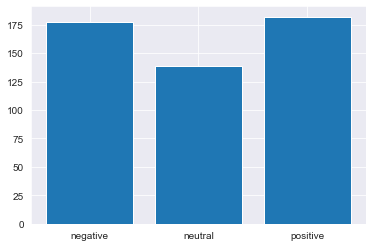

In [36]:
plot_label_count(test_df)

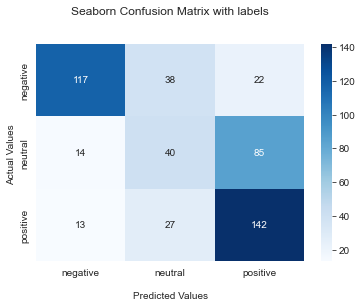

In [37]:
plot_confusion_matrix(confusion_matrix(test_df['target'], test_df['predictions']))

## Scrape and predict sentiment

In [88]:
keyword="covid"

In [89]:
sentiment, text_sentiment, tweet_df = scrape_and_predict(keyword=keyword, start_date="2020-01-30", end_date="now", max_tweets=10000)

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

10001it [09:43, 17.13it/s]                          


  0%|          | 0/10001 [00:00<?, ?it/s]

In [90]:
tweet_df['sentiment_label'] = text_sentiment
tweet_df['text_length'] = [len(text) for text in tweet_df['rawContent']]

In [91]:
def plot_sentiment(tweet_df):
    sent_cl = np.unique(tweet_df["sentiment_label"])

    counts = [np.sum(np.array(tweet_df['sentiment_label']) == cl) for cl in sent_cl]

    fig, ax = plt.subplots(1,1)

    ax.bar(sent_cl, counts)
    return

def plot_text_lengths(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'negative'], shade=True, color="r", ax=ax, label="negative")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'neutral'], shade=True, color="b", ax=ax, label="neutral")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'positive'], shade=True, color="g", ax=ax, label="positive")
    ax.set_xlim(-10, 500)
    ax.legend()
    ax.set_title("Text length per sentiment label")

def plot_date_dist(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.histplot(tweet_df['date'], ax=ax)

    ax.tick_params(axis='x', rotation=60)
    ax.set_title("Tweet frequency over time")

In [92]:
def plot_stacked_bar(tweet_df):
    sentiment_month = pd.DataFrame(tweet_df.groupby([tweet_df.date.dt.year, tweet_df.date.dt.month, 'sentiment_label']).size())

    years = []
    months = []
    sentiments = []

    datetime_col = pd.to_datetime({'year': [i[0] for i in list(sentiment_month.index)],
                             'month': [i[1] for i in list(sentiment_month.index)],
                             'day': [1 for i in range(len(sentiment_month.index))]})
    sentiments = [i[2] for i in list(sentiment_month.index)]
    sentiment_month = sentiment_month.reset_index(drop=True)
    sentiment_month["date"] = datetime_col
    sentiment_month["sentiment"] = sentiments

    totals = sentiment_month.groupby("date").sum()[0]

    def get_percentage(x):
        return x[0] / totals[x['date']]

    sentiment_month['ratio'] = sentiment_month.apply(get_percentage, axis=1)

    negative = sentiment_month[sentiment_month['sentiment'] == 'negative']['ratio'].to_numpy()
    neutral = sentiment_month[sentiment_month['sentiment'] == 'neutral']['ratio'].to_numpy()
    positive = sentiment_month[sentiment_month['sentiment'] == 'positive']['ratio'].to_numpy()
    dates = sentiment_month[sentiment_month['sentiment'] == 'negative']['date'].to_list()

    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.bar(dates, negative, width=10, color='r')
    ax.bar(dates, neutral, width=10, bottom=negative, color='b')
    ax.bar(dates, positive, width=10, bottom=negative+neutral, color='g')

    plt.show()
    return sentiment_month

In [93]:
#plt.style.use('dark_background')
plt.style.use('seaborn-notebook')

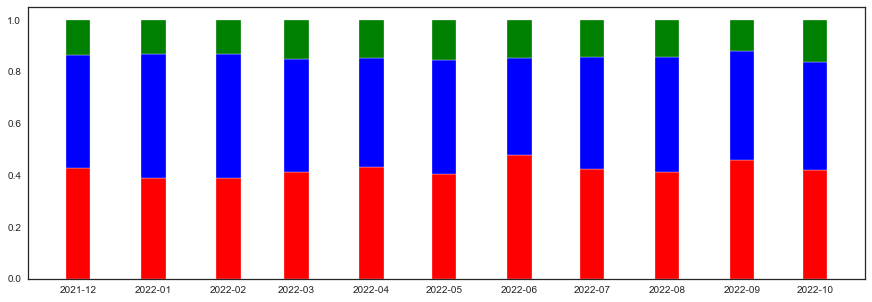

,0,date,sentiment,ratio
0,275,2021-12-01,negative,0.427019
1,282,2021-12-01,neutral,0.437888
2,87,2021-12-01,positive,0.135093
3,742,2022-01-01,negative,0.390116
4,909,2022-01-01,neutral,0.477918
5,251,2022-01-01,positive,0.131966
6,350,2022-02-01,negative,0.389321
7,431,2022-02-01,neutral,0.479422
8,118,2022-02-01,positive,0.131257
9,406,2022-03-01,negative,0.412602


In [94]:
plot_stacked_bar(tweet_df)

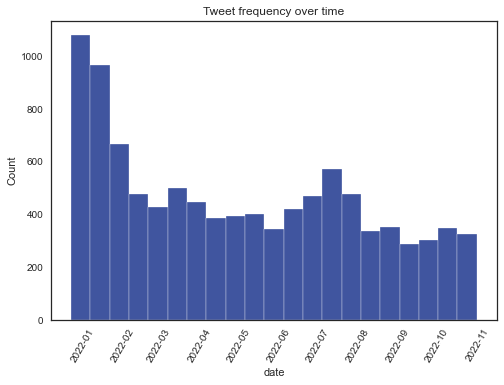

In [96]:
plot_date_dist(tweet_df)

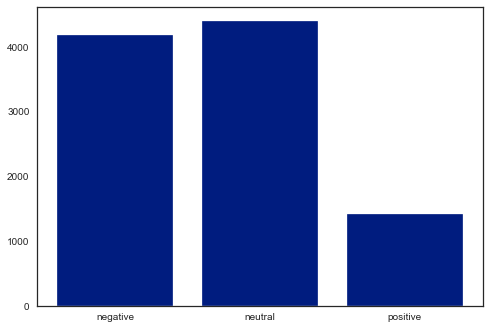

In [98]:
plot_sentiment(tweet_df)

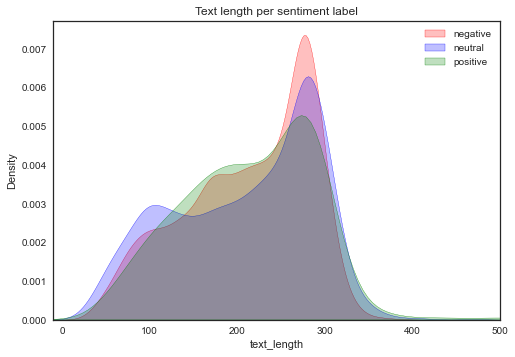

In [99]:
plot_text_lengths(tweet_df)

In [104]:
def get_word_cloud_text(tweet_df):
    tweet_tokens = []
    for tweet in tqdm(tweet_df['rawContent']):
        tweet_tokens.extend(tokenize(tweet))

    return " ".join(token for token in tweet_tokens)


def get_word_cloud_text(tweet_df):
    all_tweets = " ".join(tweet for tweet in tweet_df['rawContent'])
    all_tweets_tokens = process_token_list(tokenize(all_tweets))
    return " ".join(token for token in all_tweets_tokens)


def plot_word_cloud(tweet_df, keyword, sentiment_class=None):
    stopwords = set(STOPWORDS)
    stopwords.update({"<url>", "<user>", "user", "s", "url", "hashtag", keyword})
    word_cloud = WordCloud(stopwords=stopwords, min_word_length=3, width=800, height=400)

    if not sentiment_class:
        text = get_word_cloud_text(tweet_df)
    else:
        text = get_word_cloud_text(tweet_df[tweet_df['sentiment_label'] == sentiment_class])

    word_cloud.generate(text)

    fig, ax = plt.subplots(1,1, figsize=(20,40))
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")
    plt.show()



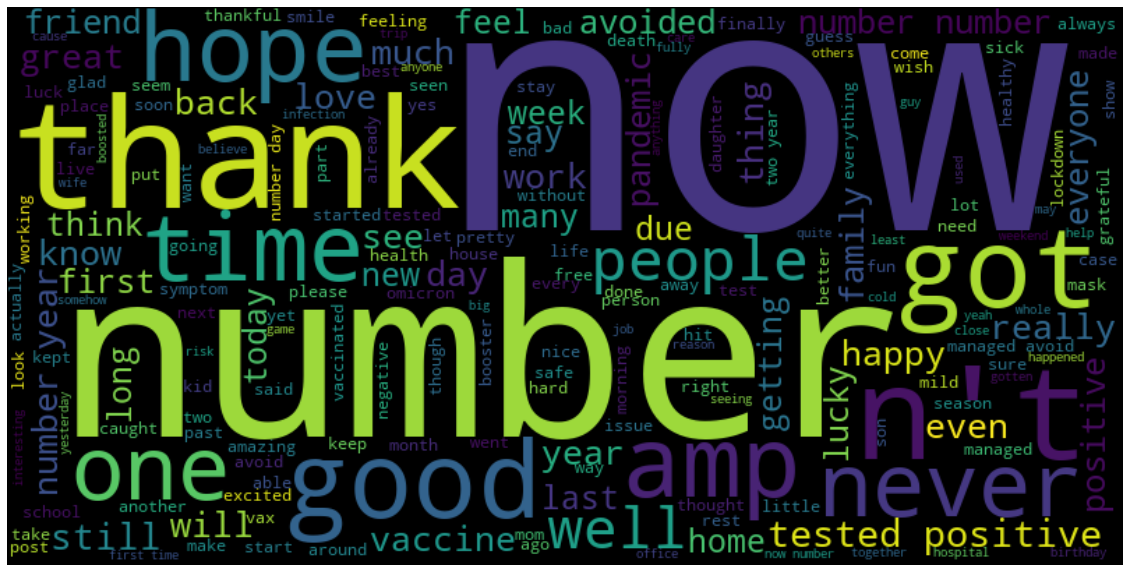

In [105]:
plot_word_cloud(tweet_df, keyword, "positive")

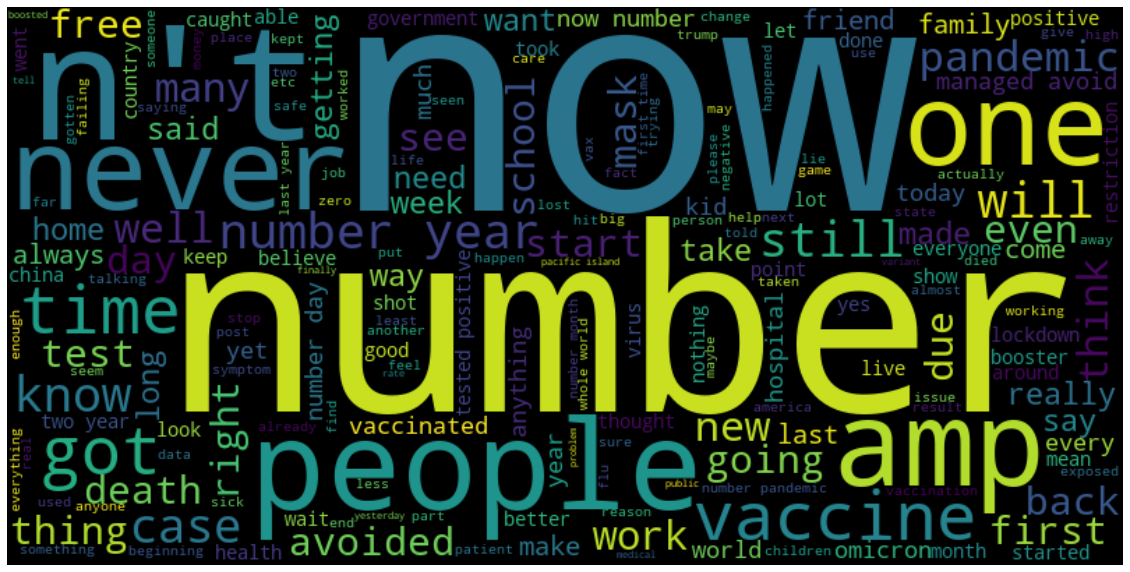

In [106]:
plot_word_cloud(tweet_df, keyword, "neutral")

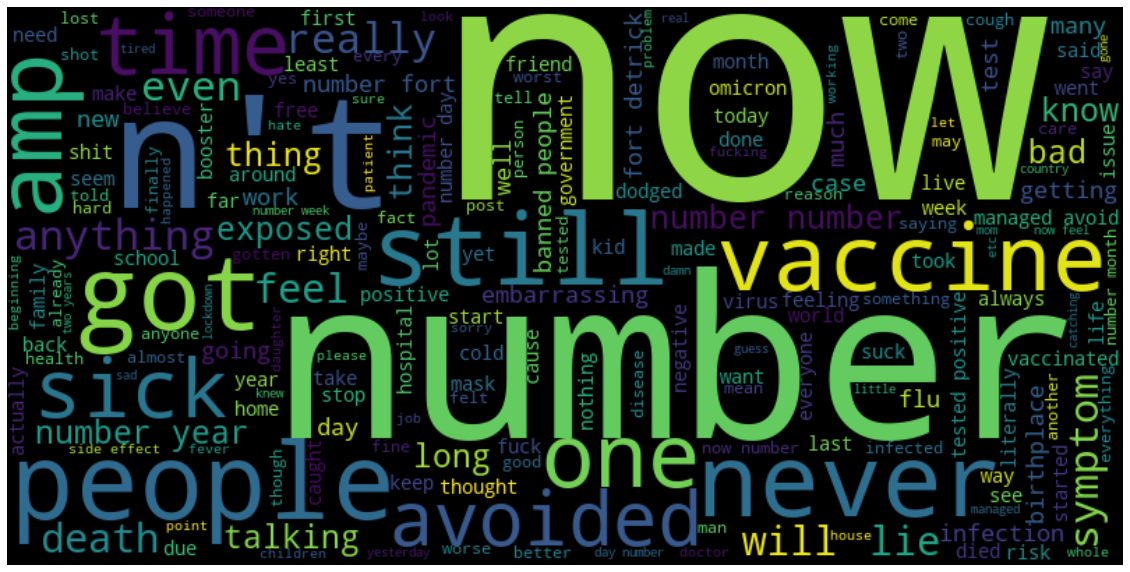

In [107]:
plot_word_cloud(tweet_df, keyword, "negative")